In [79]:
# Death estimates following Islam et al. roughly but with different confidence interval computations
# that are cross-validated and thus provide more confidence that they indeed have the correct coverage. (pun intended)
# https://www.repository.cam.ac.uk/bitstream/handle/1810/322784/bmj-373-bmj-n1137.pdf?sequence=4
# Supplement: https://www.bmj.com/content/bmj/suppl/2021/05/19/bmj.n1137.DC1/isln065519.ww1.pdf
# Also interesting paper to note is Karlinsky et al who assume standard normal errors, which is not accurate as we shall
# see below : https://elifesciences.org/articles/71974
library(stringr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(ISOweek)
library(scales)
library(zoo)
library(tidyr)
library(quantreg)
library(splines)
library(pbs)
library(forecast)
require(RcppRoll)
library(fpp2)
library(xts)
library(VGAM)

Loading required package: stats4



In [ ]:
# download mortality data from saved query from https://www.ssb.no/en/statbank/table/07995/

# Update alternatives: Update the query with a fixed starting time point and the new time periods
# Format: Semicolon delimited with heading (csv)
FIGURE_FOLDER = "../figures/norwegian/"

download.file("https://www.ssb.no/en/statbank/sq/10077135", "../data/nor_death.csv")

In [48]:
download.file("https://www.ssb.no/en/statbank/sq/10077137", "../data/nor_pop.csv")

In [49]:
raw_deaths = read.csv("../data/nor_death.csv", sep=";", header=TRUE, skip=2, stringsAsFactors=FALSE, 
                  fileEncoding="latin1")
raw_pop = read.csv("../data/nor_pop.csv", sep=";", header=TRUE, skip=2, stringsAsFactors=FALSE, 
                  fileEncoding="latin1")

In [50]:
deaths = raw_deaths[raw_deaths$age != "All ages", ]
deaths$age = as.numeric(str_extract(deaths$age, "(\\d+)"))
deaths$week = as.numeric(str_extract(deaths$week, "(\\d+)"))
deaths$sex = as.factor(deaths$sex)
levels(deaths$sex) = list(b=deaths$sex[1]) # This assumes one gender only (both)
deaths = pivot_longer(deaths, 
                      cols=starts_with("Deaths"), names_to="year", names_prefix="Deaths.", 
                      values_to="death")

deaths$year = as.numeric(deaths$year)
deaths$death[deaths$death == "."] = 0 # This is the NA string
deaths$death = as.numeric(deaths$death)
head(deaths)

sex,age,week,year,death
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
b,0,1,2013,2
b,0,1,2014,2
b,0,1,2015,3
b,0,1,2016,1
b,0,1,2017,6
b,0,1,2018,1


In [51]:
head(raw_pop)

,sex,age,Persons.2013,Persons.2014,Persons.2015,Persons.2016,Persons.2017,Persons.2018,Persons.2019,Persons.2020,Persons.2021,Persons.2022
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Males,0 years,31026,30330,30544,30545,30650,29337,28556,28208,27129,28886
2,Males,1 year,31653,31532,30674,30896,30862,31029,29649,28847,28422,27378
3,Males,2 years,32432,32035,31840,30827,31108,31115,31187,29823,28947,28560
4,Males,3 years,33101,32758,32289,32053,31024,31261,31157,31261,29825,29032
5,Males,4 years,32647,33362,32943,32399,32213,31175,31303,31274,31278,29931
6,Males,5 years,31671,32859,33554,33159,32536,32345,31242,31375,31274,31337


In [52]:
pop = raw_pop[raw_pop$age != "Alle aldre", ]
pop$age = as.numeric(str_extract(pop$age, "(\\d+)"))
# pop$age = as.factor(pop$age)
pop$sex = as.factor(pop$sex)
pop = pivot_longer(pop, 
                      cols=starts_with("Persons"), names_to="year", names_prefix="Persons.", 
                      values_to="pop")
pop$year = as.numeric(pop$year)
pop$pop = as.numeric(pop$pop)
tail(pop)


sex,age,year,pop
<fct>,<dbl>,<dbl>,<dbl>
Females,105,2017,44
Females,105,2018,50
Females,105,2019,52
Females,105,2020,54
Females,105,2021,75
Females,105,2022,76


In [75]:
# Apply a function to weekly data with some window size for the week to include.

rolling_weekly = function(y, week, fxn, k=3, ...) {
    k = 5 # window size for rolling quantiles: MUST be odd 
    weeks_per_year = 52
    weekly = data.frame(week=seq(1:52), result=rep(0, 52))
    for (i in c(1:52)) {
        # This code organizes the indeces to be circular, -2,-1, 1, 2 etc
        a = c(0:(k - 1)) - floor(k / 2) + i
        a[a<=0] = a[a<=0] - 1
        a[a>=52] = a[a>=52] %% 52 + 1
        data = y[week %in% a]
        weekly$result[i] = fxn(data, ...)
    }
    merge(data.frame(y=y, week=week), weekly, by="week")
}

# Define functions
weighted_mean = function(x) {
    nas = is.na(x)
    w = c(0.25, 0.5, 0.25)
    if (all(nas)) {
        return(0)
    } else {
        w = w[!nas] / sum(w[!nas])
        return(sum(x[!nas] * w))
    }
}

In [54]:
# First lets check Gompertz law of mortality
# The ESP age groups
esp_group = cut(deaths$age, c(0,1,seq(5,95, 5), 200), right=FALSE)
esp_groups = levels(esp_group)
gdeaths = deaths %>% group_by(age = esp_group, year, week) %>% summarize(
    death = sum(death)
    )
tail(gdeaths)

`summarise()` has grouped output by 'age', 'year'. You can override using the
`.groups` argument.


age,year,week,death
<fct>,<dbl>,<dbl>,<dbl>
"[95,200)",2022,48,90
"[95,200)",2022,49,92
"[95,200)",2022,50,104
"[95,200)",2022,51,87
"[95,200)",2022,52,97
"[95,200)",2022,53,0


In [55]:
pop_esp_group = cut(pop$age, c(0,1,seq(5,95, 5), 200), right=FALSE)
gpop = pop %>% group_by(age = pop_esp_group, year) %>% summarize(pop=sum(pop))
tail(gpop)

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


age,year,pop
<fct>,<dbl>,<dbl>
"[95,200)",2017,9872
"[95,200)",2018,10275
"[95,200)",2019,10420
"[95,200)",2020,10780
"[95,200)",2021,11055
"[95,200)",2022,11244


In [184]:
# Remove gap year week 53
weeks = gdeaths$week
weeks[nchar(weeks) == 1] <- paste0("0", weeks[nchar(weeks) == 1])
week_pattern = paste(gdeaths$year, paste("W", weeks, sep=""), 
                   7, sep="-")
gdeaths$date = ISOweek2date(week_pattern) + days(1)
gdeaths = gdeaths[gdeaths$week != 53,]
head(gdeaths)

age,year,week,death,date
<fct>,<dbl>,<dbl>,<dbl>,<date>
"[0,1)",2013,1,2,2013-01-07
"[0,1)",2013,2,2,2013-01-14
"[0,1)",2013,3,1,2013-01-21
"[0,1)",2013,4,1,2013-01-28
"[0,1)",2013,5,3,2013-02-04
"[0,1)",2013,6,1,2013-02-11


In [185]:
# we see almost 10% of rows have zero deaths. This is fixed by smoothing with a central
# kernel with weights 0.25, 0.5, 0.25 (rolling weekly)
merged = merge(gdeaths, gpop, by=c("year", "age"))
merged$end_age = gsub("\\[\\d+,", "", as.character(merged$age), perl=TRUE)
merged$end_age = as.numeric(gsub("\\)", "", as.character(merged$end_age), perl=TRUE)) - 1
merged$end_age[merged$end_age %in% c(199, 200)] = 105
merged$start_age = as.numeric(str_extract(merged$age, "\\d+"))
merged$avg_age = (merged$start_age + merged$end_age) / 2

sprintf("Fraction of data missing %.2f", dim(merged[merged$death==0,])[1] / dim(merged)[1])
# With a smoother we are down to 3%. This is managable
merged<-arrange(merged, age, date) %>%
       mutate(sdeaths=rollapply(death, 3, weighted_mean, align='center',fill=TRUE))
sprintf("Fraction of data missing after smoothing %.2f", dim(merged[merged$sdeaths==0,])[1] / dim(merged)[1])



[1] "Fraction of data missing 0.12"

[1] "Fraction of data missing after smoothing 0.04"

Warning message:
“Removed 1071 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 1071 rows containing missing values (`geom_line()`).”


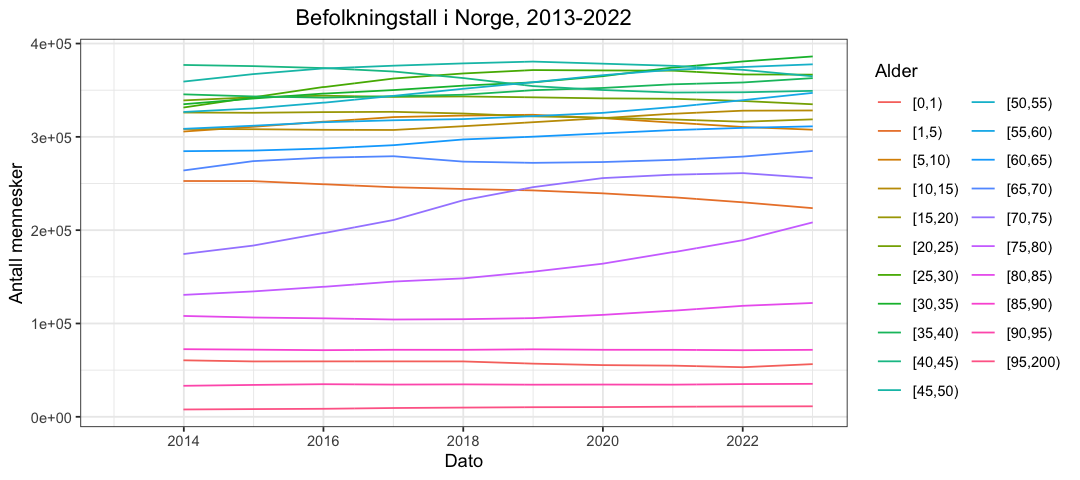

In [186]:
# Interpolate population data linearly between week 52 each year
options(repr.plot.width=9, repr.plot.height=4)
merged$pop[merged$week != 52] = NA
merged = merged %>%
  group_by(age) %>%
    arrange(age, date) %>%
    mutate(time=seq(1,n())) %>%
      mutate(pop.interp=approx(time,pop,time)$y) %>%
      select(-time)
ggplot(merged, aes(date, pop.interp, color=age)) + geom_line() +
# scale_y_continuous(trans='log10') +
labs(x="Dato", y="Antall mennesker", title="Befolkningstall i Norge, 2013-2022", color="Alder") +
theme_bw() +
theme(plot.title=element_text(hjust=.5))
ggsave(paste(FIGURE_FOLDER, "population_rates.png", sep=""), width=7, height=3)

In [187]:
# Remove rows with with no population data (anything less than year 2001)
merged = subset(merged, sdeaths != 0 & !is.na(merged$pop.interp))
merged$mu = merged$sdeaths / merged$pop.interp
merged$lnmu = log(merged$mu)

head(merged)

year,age,week,death,date,pop,end_age,start_age,avg_age,sdeaths,pop.interp,mu,lnmu
<dbl>,<fct>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013,"[0,1)",52,3,2013-12-30,60530,0,0,0,2.75,60530.00,4.543202e-05,-9.999293
2014,"[0,1)",1,2,2014-01-06,NA,0,0,0,2.50,60507.02,4.131752e-05,-10.094224
2014,"[0,1)",2,3,2014-01-13,NA,0,0,0,3.00,60484.04,4.959986e-05,-9.911522
2014,"[0,1)",3,4,2014-01-20,NA,0,0,0,4.00,60461.06,6.615829e-05,-9.623460
2014,"[0,1)",4,5,2014-01-27,NA,0,0,0,4.50,60438.08,7.445637e-05,-9.505297
2014,"[0,1)",5,4,2014-02-03,NA,0,0,0,4.25,60415.10,7.034666e-05,-9.562075


In [188]:
get_figloc = function(figname) {
    paste(FIGURE_FOLDER, figname, sep="")
}

In [189]:
# Plot deaths rates by age
age_deaths = subset(merged, year < 2020) %>% group_by(avg_age, year) %>% summarize(sdeaths=sum(sdeaths, na.rm=TRUE), pop=pop.interp) %>% distinct()
age_deaths$lnmu = log(age_deaths$sdeaths / age_deaths$pop)
rates = age_deaths %>% dplyr::group_by(avg_age) %>% dplyr::summarise(mean_lnmu=mean(lnmu), sd_lnmu=sd(lnmu, na.rm=TRUE))
rates = rename(rates, age = avg_age)

`summarise()` has grouped output by 'avg_age', 'year'. You can override using
the `.groups` argument.


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


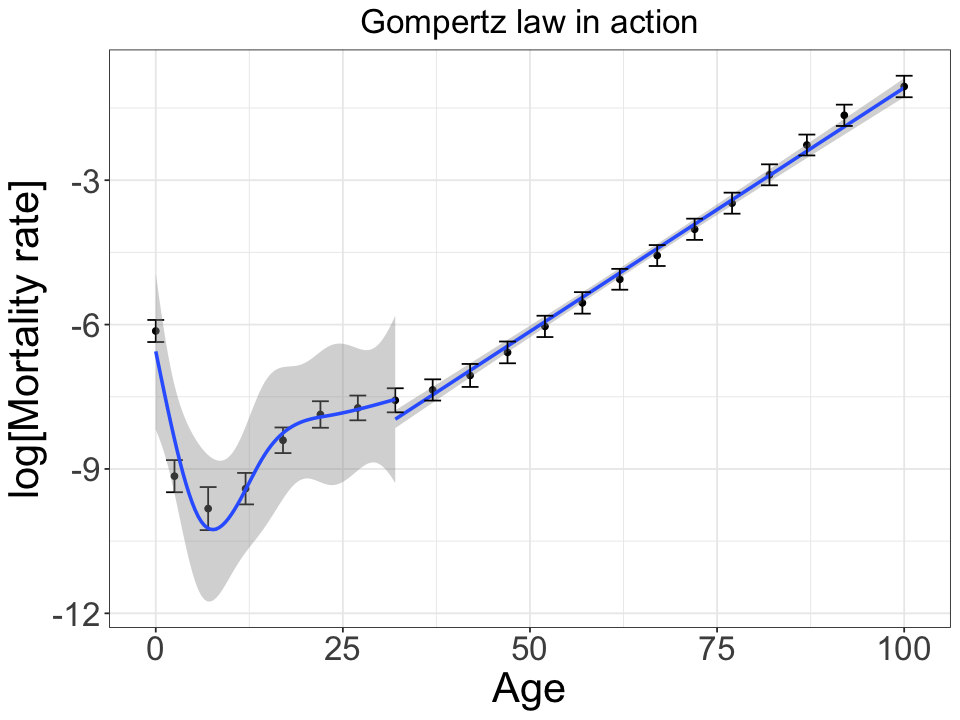

In [190]:
# We see that the relationship is simple after 30 years of age. Before we need to be careful.
options(repr.plot.width=8, repr.plot.height=6)
a = ggplot(rates, aes(age, mean_lnmu))
a + geom_point() + geom_smooth(data=subset(rates, age > 30), method = "lm", se=TRUE) +
geom_errorbar(aes(ymin=mean_lnmu - sd_lnmu, ymax=mean_lnmu + sd_lnmu)) +
geom_smooth(data=subset(rates, age <= 35), method = "lm", formula=y~ns(x, df=4), se=TRUE) +
labs(x = "Age", y = "log[Mortality rate]", title="Gompertz law in action") +
theme_bw() +
theme(plot.title=element_text(size=20, hjust=.5), axis.text=element_text(size=20), axis.title=element_text(size=25))

ggsave(get_figloc("norway_gompertz_law_ln_mortality_rates.png"), width=10, height=5)

,age,year,week,death,date,pop,end_age,start_age,avg_age,sdeaths,pop.interp,mu,lnmu,esp_pop,smooth_deaths_norm
,<fct>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"[0,1)",2013,52,3,2013-12-30,60530,0,0,0,2.75,60530.00,4.543202e-05,-9.999293,1000,0.04543202
2,"[0,1)",2014,1,2,2014-01-06,NA,0,0,0,2.50,60507.02,4.131752e-05,-10.094224,1000,0.04131752
3,"[0,1)",2014,2,3,2014-01-13,NA,0,0,0,3.00,60484.04,4.959986e-05,-9.911522,1000,0.04959986
4,"[0,1)",2014,3,4,2014-01-20,NA,0,0,0,4.00,60461.06,6.615829e-05,-9.623460,1000,0.06615829
5,"[0,1)",2014,4,5,2014-01-27,NA,0,0,0,4.50,60438.08,7.445637e-05,-9.505297,1000,0.07445637
6,"[0,1)",2014,5,4,2014-02-03,NA,0,0,0,4.25,60415.10,7.034666e-05,-9.562075,1000,0.07034666


`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


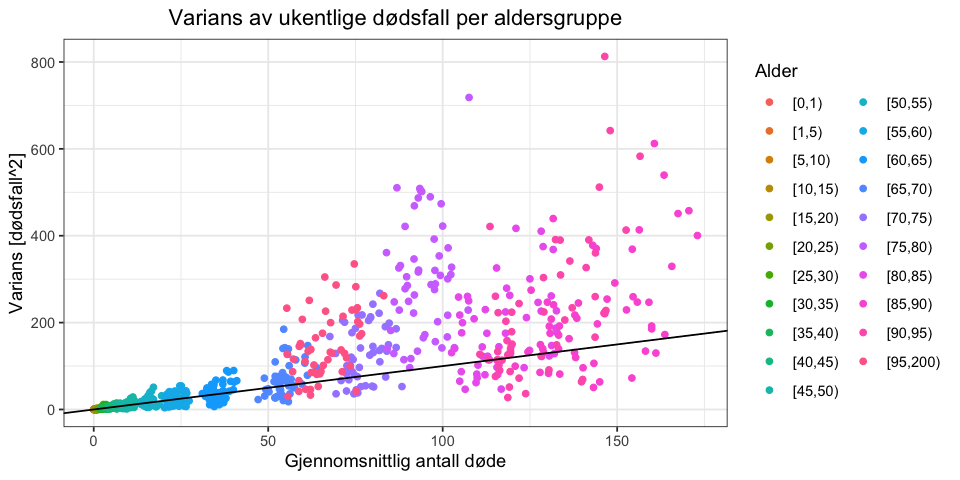

In [191]:
esp_pop = c(1000, 4000, 5500, 5500, 5500, 6000, 6000, 6500, 7000, 
            7000, 7000, 7000, 6500, 6000, 5500, 5000, 4000, 2500, 1500, 800, 200)
esp_pop = data.frame(age=esp_groups, esp_pop=esp_pop)
options(repr.plot.width=8, repr.plot.height=4)
norm = merge(merged, esp_pop, by="age")
norm$smooth_deaths_norm = norm$mu * norm$esp_pop
head(norm)

ggplot(norm %>% group_by(age, week) %>% 
      summarise(avg=mean(death), var=var(death)), aes(avg, var, color=age)) + 
#        summarise(avg=mean(death), var=var(death)), aes(avg, var, color=age)) + 
geom_point() +
geom_abline(slope=1) + 
theme_bw() + labs(color="Alder", x="Gjennomsnittlig antall døde", y="Varians [dødsfall^2]", title="Varians av ukentlige dødsfall per aldersgruppe")+
theme(plot.title=element_text(hjust=.5))
ggsave(get_figloc("weekly_deaths_variance.png"), width=8, height=4)


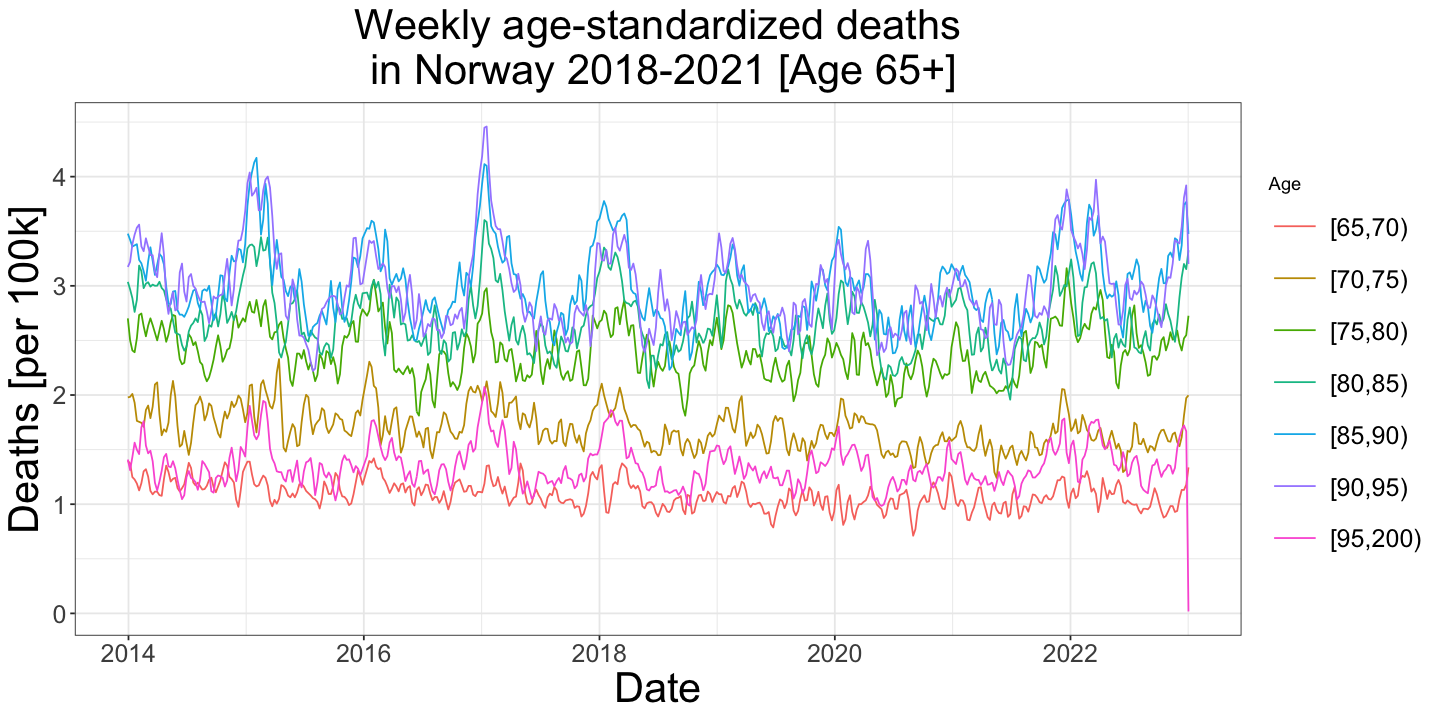

In [192]:
options(repr.plot.width=12, repr.plot.height=6)
n_groups = length(esp_groups)
subset = subset(norm, age %in% esp_groups[(n_groups-6):n_groups] & year > 2000)
a = ggplot(subset, aes(x=date, y=smooth_deaths_norm, color=age))
a + geom_line() +
theme(title=element_text(size=20), axis.text=element_text(size=20), axis.title=element_text(size=25)) +
labs(x = "Date", y = "Deaths [per 100k]", title="Weekly age-standardized deaths\n in Norway 2018-2021 [Age 65+]") +
theme_bw() +
theme(plot.title=element_text(size=25, hjust=.5), 
      axis.text=element_text(size=15), 
      legend.text=element_text(size=15), 
      axis.title=element_text(size=25), 
      legend.key.size=unit(1.1, "cm")) +
scale_color_discrete("Age")
ggsave(get_figloc("norway_age-std_deaths.png"), width=10, height=6)

In [193]:
# Sum all deaths in specified age bracket
# ESP combined deaths
FIXED_POP_NUMBER = 100000
high_deaths = subset(norm, start_age > 64) %>% group_by(week, year) %>% 
    summarise(deaths=sum(smooth_deaths_norm),
              lnmu=log(sum(smooth_deaths_norm)),
#               pop.interp.weighted=sum(esp_pop * pop.interp)/sum(esp_pop),
              pop.interp=sum(pop.interp),
              sum_esp_pop=sum(esp_pop),
              date=date,
              age_group="high") %>% distinct()
high_deaths$days = high_deaths$date - high_deaths$date[1]

mid_deaths = subset(norm, start_age <= 64 & start_age >= 15) %>% group_by(week, year) %>% 
    summarise(deaths=sum(smooth_deaths_norm),
              lnmu=log(sum(smooth_deaths_norm)),
#               pop.interp.weighted=sum(esp_pop * pop.interp)/sum(esp_pop),
              pop.interp=sum(pop.interp),
              sum_esp_pop=sum(esp_pop),
              date=date,
             age_group="mid") %>% distinct()
mid_deaths$days = mid_deaths$date - mid_deaths$date[1]

adult_deaths = subset(norm, start_age >= 15) %>% group_by(week, year) %>% 
    summarise(deaths=sum(smooth_deaths_norm),
              lnmu=log(sum(smooth_deaths_norm)),
#               pop.interp.weighted=sum(esp_pop * pop.interp)/sum(esp_pop),
              pop.interp=sum(pop.interp),
              sum_esp_pop=sum(esp_pop),
              date=date,
             age_group="adult") %>% distinct()
adult_deaths$days = adult_deaths$date - adult_deaths$date[1]
all_deaths = rbind(adult_deaths, high_deaths, mid_deaths)
tail(all_deaths)

`summarise()` has grouped output by 'week', 'year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'week', 'year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'week', 'year'. You can override using the
`.groups` argument.


week,year,deaths,lnmu,pop.interp,sum_esp_pop,date,age_group,days
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>,<drtn>
52,2017,2.223675,0.7991610,3445785,64500,2018-01-01,mid,1456 days
52,2018,2.140875,0.7612145,3460260,64500,2018-12-31,mid,1820 days
52,2019,2.006515,0.6963995,3474413,64500,2019-12-30,mid,2184 days
52,2020,1.709105,0.5359696,3495637,64500,2020-12-28,mid,2548 days
52,2021,1.853619,0.6171400,3504036,64500,2022-01-03,mid,2919 days
52,2022,2.332953,0.8471349,3519809,64500,2023-01-02,mid,3283 days


In [194]:
get_percentage = function(x) {
    (exp(x) - 1) * 100  # (deaths / exp(b*annual + c*weekly + intercept) - 1) * 100
}
mortality_fit = function(
    data, 
    # Parameters
    years_per_df = 5,
    df.weekly = 4,
    df.res = 2,
    alpha=0.10,
    response.col = "Sdeaths_norm",
    debug=FALSE,
    cv=FALSE) {
    # This function fits trends and confidence intervals at the alpha level
    # Enforced column names in input data
    
    test_start_year = 2020
    start_year = 2012
    
    week.col = "Week"
    year.col = "Year"
    date.col = "Date"
    sex.col = "Sex"
    country.col = "CountryCode"
    age.col = "Age"
    pop.col = "Pop_int"

    all = data.frame(date = data[,date.col],
                    week = as.numeric(unlist(data[,week.col])),
                    year = as.numeric(unlist(data[,year.col])),
                    response=log(data[, response.col]),
                    sex = as.factor(unlist(data[,sex.col])),
                    country = as.factor(unlist(data[,country.col])),
                    age = as.factor(unlist(data[,age.col])),
                    pop = as.numeric(unlist(data[,pop.col])))
    
    colnames(all) = c("date", "week", "year", "response", "sex", "country", "age", "pop")
    df.yearly = floor(max((test_start_year - min(all$year)) / years_per_df, 2))
    print(sprintf("Using %d degrees of freedom in yearly splines for %s, %s, %s", 
            df.yearly, all$country[1], all$age[1], all$sex[1]))
    all = subset(all, year(date) > start_year)
    train = subset(all, year(date) < test_start_year)
    test = subset(all, year(date) >= test_start_year)

    yearly.fit = rq(response ~ ns(date, df=df.yearly), data=train)

    train[, "res.yearly"] = yearly.fit$res
    train[, "fit.yearly"] = yearly.fit$fit
    weekly.fit = rq(res.yearly ~ 0 + pbs(week, df=df.weekly), data=train)
    
    train[, "fit.weekly"] = weekly.fit$fit
    train[, "res.weekly"] = weekly.fit$res
    train = train %>% mutate(centered = response - fit.weekly - fit.yearly)
    # Set test date to last train date to fix yearly trend in test period
    mod_date = all$date
    mod_date[year(mod_date) >= test_start_year] = as.Date("2019-12-31", "%Y-%m-%d")
    mod_all = data.frame(date=mod_date, week=all$week)
    all$fit.yearly = predict(yearly.fit, newdata=mod_all)
    all$fit.weekly = predict(weekly.fit, newdata=mod_all)
    
    all = all %>% mutate(centered = response - fit.weekly - fit.yearly)
    n_train = nrow(train)
    n_all = nrow(all)
    # Simple constant quantile c.i.
    if (df.res <= 2) {
        fit.low = quantile(train$centered, alpha/2)
        fit.high = quantile(train$centered, 1 - alpha/2)
        train$centered_high = rep(fit.high, n_train)
        train$centered_low = rep(fit.low, n_train)
        all$centered_high = rep(fit.high, n_all)
        all$centered_low = rep(fit.low, n_all)
    } else {
        fit.low = rq(centered ~ 0 + pbs(week, df=df.res), data=train, tau=alpha/2)
        fit.high = rq(centered ~ 0 + pbs(week, df=df.res), data=train, tau=1-alpha/2)
        train$centered_high = fit.high$fit
        train$centered_low = fit.low$fit
        all$centered_high = predict(fit.high, newdata=all)
        all$centered_low = predict(fit.low, newdata=all)
    }
    
    test = subset(all, year(date) > 2020)
    frac_outside = sum(train$centered < train$centered_low | train$centered > train$centered_high) / nrow(train)
    frac_outside_test = sum(test$centered < test$centered_low | test$centered > test$centered_high) / nrow(test)
    frac_over_test = sum(test$centered > test$centered_high) / nrow(test)
    if (debug) {
        print(sprintf("Fraction of observations outside confidence band in pre-2020: %.3f", frac_outside))
        print(sprintf("Fraction of observations outside confidence band in 2021: %.3f", frac_outside_test))
        print(sprintf("Fraction of observations over confidence band in 2021: %.3f", frac_over_test))
    }
    if (cv) {
        return(list(df=all, weekly.fit=weekly.fit))
    }
    return(all)
}

plot_debug = function(df) {
    ggplot(df, aes(date, response)) + geom_line(alpha=0.3) + 
    geom_line(aes(date, fit.yearly), size=1.5, color="blue") + 
    geom_line(aes(date, fit.weekly + fit.yearly), size=1.5, color="gold") +
    geom_ribbon(aes(ymin=centered_low + fit.weekly + fit.yearly, 
                    ymax=centered_high + fit.weekly + fit.yearly), alpha=0.3) + 
    labs(x="Date", y="Deaths [per 100k per week]", title="Anomalous Mortality 2012-2022") 
}
plot_mortality = function(df) {
    ggplot(df, aes(date, get_percentage(centered))) + geom_line(alpha=0.3) + 
    geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
    geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high)), alpha=0.3) + 
    labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") 

}
# Cross-validate to find best smoothing parameter by minimizing out-of-sample 
# deviation from estimated exceedence. I.e. for a 95% confidence band, we will expect 
# 5% of out-of-sample estimates to be outside this band. We thus choose the smallest number 
# of parameters that get us there.
# Conclusion: The predictive power is not dependent on degrees of freedom of smoothing
# options(repr.plot.width=7, repr.plot.height=4)
cv_mortality = function(cdata,
                       years_per_df = 5,
                       test_start_year = 2020,
                       cv_type="week",  # week or "res" for residuals spline degrees of freedom
                       dfs=c(2, 4, 6, 8, 10, 12, 14, 16, 18, 20),
                       df_other=2,
                       response="Sdeaths_norm") {

    # TODO: make df_opther into a vector of same length as dfs
    
    all = cdata %>% rename(week=Week, year=Year, age=Age, date=Date, country=CountryCode, sex=Sex, 
                     response=all_of(response))
    all$week = as.numeric(all$week)
    all$year = as.numeric(all$year)
    
    df.yearly = floor(max((test_start_year - min(all$year)) / years_per_df, 2))
    train = subset(all, year < 2020 & year > 2012)
    alpha = 0.05 # Confidence interval

    years = unique(train$year)
    n_years = length(years)
    n_dfs = length(dfs)
    te_hat = matrix(0, n_years, n_dfs)
    tr_hat = matrix(0, n_years, n_dfs)
    sd_ratio_hat = matrix(0, n_years, n_dfs)
    INFL = 1.
    out = vector(mode="list", length=n_years)
    if (cv_type == "week") {
        dfs_week = dfs
        dfs_res = rep(df_other, length(dfs))
    } else if (cv_type == "res") {
        dfs_res = dfs
        dfs_week = rep(df_other, length(dfs))
    }

    for (i in 1:n_years) {
        out[[i]] = vector(mode="list", length=n_dfs)

        for (j in 1:n_dfs) {
            m_year = years[i]
            
            tr = subset(train, year != m_year)
            te = subset(train, year == m_year)
            n_tr = nrow(tr)
            n_te = nrow(te)
            yearly.fit = rq(response ~ ns(date, df=df.yearly), data=tr)

            tr[, "res.yearly"] = yearly.fit$res
            tr[, "fit.yearly"] = yearly.fit$fit

            if (dfs_week[j] <= 2) {
                weekly.fit = rq(res.yearly ~ week, data=tr)
            } else {
                weekly.fit = rq(res.yearly ~ 0 + pbs(week, df=dfs_week[j]), data=tr)
            }

            tr[, "fit.weekly"] = weekly.fit$fit
            tr[, "res.weekly"] = weekly.fit$res
            tr = tr %>% mutate(centered = response - fit.weekly - fit.yearly)
            te$fit.yearly = predict(yearly.fit, newdata=te)
            te$fit.weekly = predict(weekly.fit, newdata=te)

            te = te %>% mutate(centered = response - fit.weekly - fit.yearly)

            if (dfs_res[j] <= 2) {
                fit.low = quantile(tr$centered, alpha/2)
                fit.high = quantile(tr$centered, 1 - alpha/2)      
                tr$high = rep(fit.high, n_tr)
                tr$low = rep(fit.low, n_tr)
                te$high = rep(fit.high, n_te)
                te$low = rep(fit.low, n_te)
            } else {
                fit.low = rq(centered ~ 0 + pbs(week, df=dfs_res[j]), data=tr, tau=alpha/2)
                fit.high = rq(centered ~ 0 + pbs(week, df=dfs_res[j]), data=tr, tau=1-alpha/2)
                tr$high = fit.high$fit
                tr$low = fit.low$fit
                te$high = predict(fit.high, newdata=te)
                te$low = predict(fit.low, newdata=te)
            }
            
            sd_ratio_hat[i, j] = sd(te$centered) / sd(tr$centered)
            tr_hat[i, j] = 1 - (sum(tr$low > tr$centered | tr$high < tr$centered) / nrow(tr))
            te_hat[i, j] = 1 - (sum(te$low > te$centered | te$high < te$centered) / nrow(te))
        }
    }
    
    te_oos_error = data.frame(mean=apply(te_hat, 2, median), upper=apply(te_hat, 2, quantile, .75), lower=apply(te_hat, 2, quantile, .25), dfs=dfs)
    tr_oos_error = data.frame(mean=apply(tr_hat, 2, median), upper=apply(tr_hat, 2, quantile, .75), lower=apply(tr_hat, 2, quantile, .25), dfs=dfs)
    oos_error = rbind(train=tr_oos_error, test=te_oos_error)
    oos_error$data_set = rownames(oos_error)
    oos_error$data_set = gsub("\\.*\\d", "", oos_error$data_set)
    oos_error$sex = all$sex[1]  # all rows in input must be same sex
    oos_error$country = all$country[1]  # all rows in input must be same sex
    oos_error$age = all$age[1]  # all rows in input must be same sex
    return(oos_error)
}

In [195]:

orig_deaths = norm[c("age", "year", "week", "smooth_deaths_norm", "pop.interp", "date")]
orig_deaths["CountryCode"] = "NOR"
orig_deaths["Sex"] = "b"
colnames(orig_deaths) = c("Age", "Year", "Week", "Sdeaths_norm", "Pop_int", "Date", "CountryCode", "Sex")
orig_stratified = orig_deaths %>% group_by(CountryCode, Sex, Age) %>% group_map(~ mortality_fit(.x, response.col="Sdeaths_norm"), keep=TRUE)
orig_stratified = do.call(rbind, orig_stratified)
colnames(orig_stratified)

[1] "Using 2 degrees of freedom in yearly splines for NOR, [0,1), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [1,5), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [5,10), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [10,15), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [15,20), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [20,25), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [25,30), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [30,35), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [35,40), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [40,45), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [45,50), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [50,55), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [55,60), b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, [60,65), b"
[1] "Using 

[1] "date"          "week"          "year"          "response"     
 [5] "sex"           "country"       "age"           "pop"          
 [9] "fit.yearly"    "fit.weekly"    "centered"      "centered_high"
[13] "centered_low"

In [196]:
all_deaths["CountryCode"] = "NOR"
all_deaths["Sex"] = "b"
colnames(all_deaths)
colnames(all_deaths) = c("Week", "Year", "Sdeaths_norm", "lnmu", "Pop_int", "sum_esp_pop", "Date", "Age", "days", "CountryCode", "Sex")
stratified = all_deaths %>% group_by(CountryCode, Sex, Age) %>% group_map(~ mortality_fit(.x, response.col="Sdeaths_norm"), keep=TRUE)
stratified = do.call(rbind, stratified)

[1] "week"        "year"        "deaths"      "lnmu"        "pop.interp" 
 [6] "sum_esp_pop" "date"        "age_group"   "days"        "CountryCode"
[11] "Sex"

[1] "Using 2 degrees of freedom in yearly splines for NOR, adult, b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, high, b"
[1] "Using 2 degrees of freedom in yearly splines for NOR, mid, b"


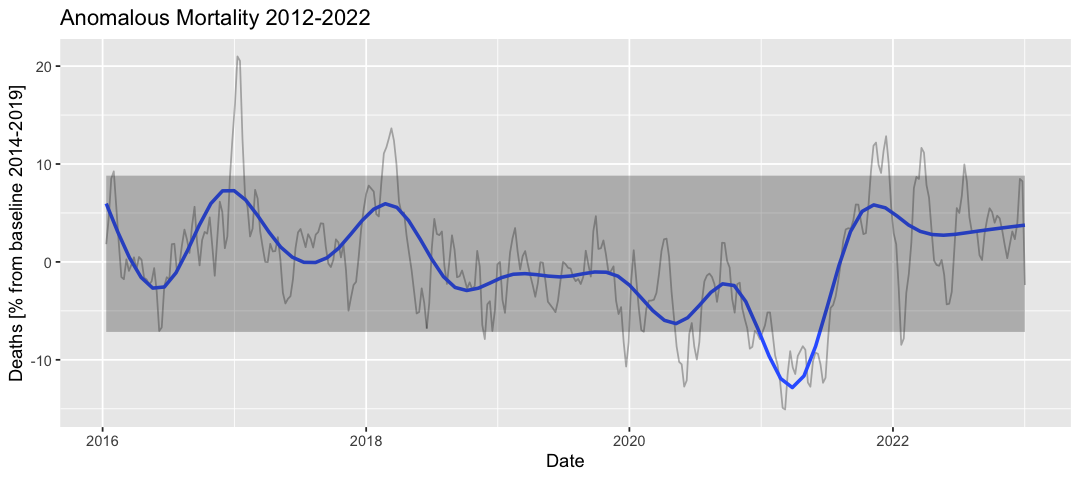

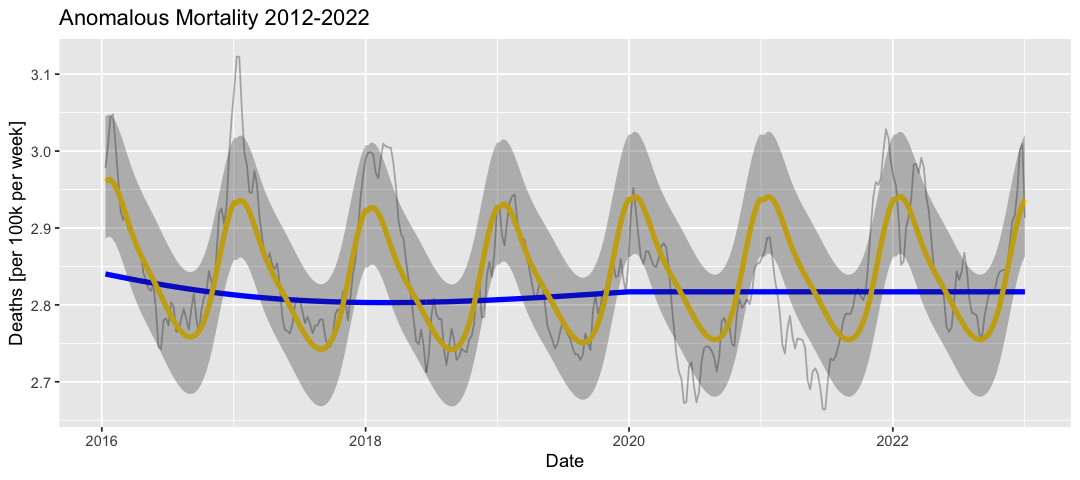

In [197]:
options(repr.plot.width=9, repr.plot.height=4)
countrysub = subset(stratified, country=="NOR" & age=="adult" & sex=="b" & year >= 2016)
plot_mortality(countrysub)
plot_debug(countrysub)

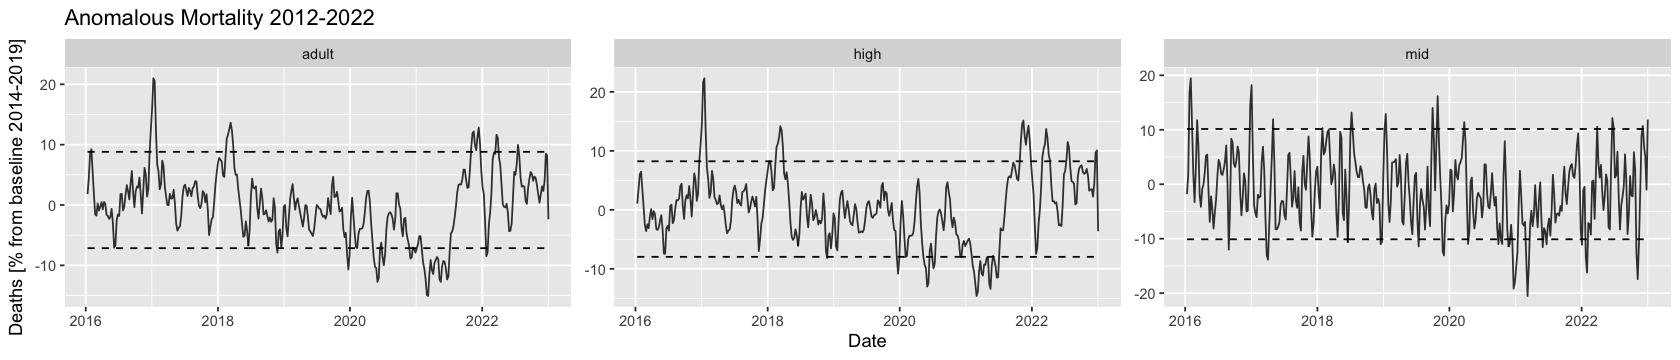

In [198]:
options(repr.plot.width=14, repr.plot.height=3)
p = ggplot(subset(stratified, year >= 2016), aes(date, get_percentage(centered))) + geom_line(alpha=0.8) + 
# geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
geom_line(aes(y=get_percentage(centered_low)), linetype=2) + 
geom_line(aes(y=get_percentage(centered_high)), linetype=2) + 
labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") + 
facet_wrap(~age, scales="free_y")
p

In [199]:
cv_ages = subset(all_deaths) %>% group_by(Age) %>% group_map(~ cv_mortality(.x), keep=TRUE)
# Cross-validate residual envelopes/quantiles degrees of freedom while keeping the weekly estimates fixed
cv_res_ages = subset(all_deaths) %>% group_by(Age) %>% 
    group_map(~ cv_mortality(.x, cv_type="res", df_other=4), keep=TRUE)

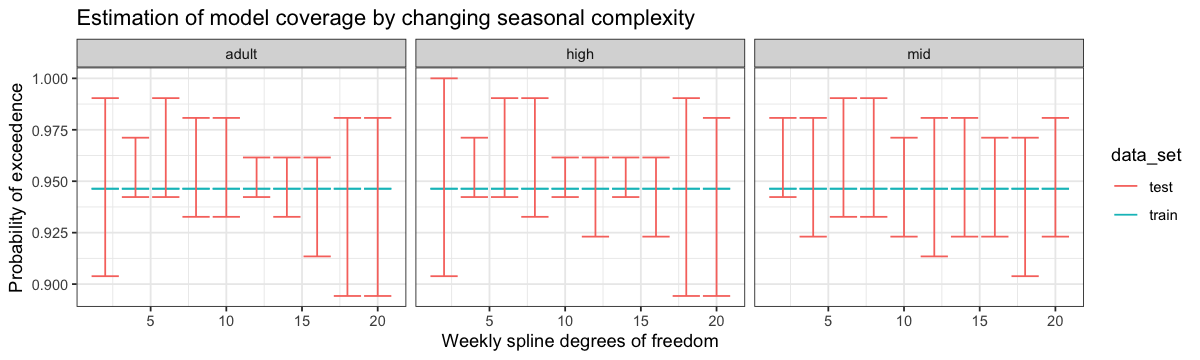

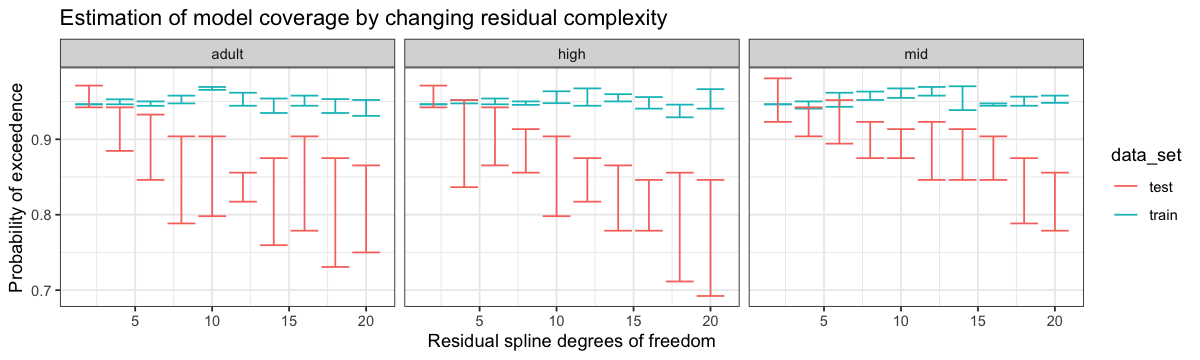

In [200]:
options(repr.plot.width=10, repr.plot.height=3)
p = ggplot(do.call(rbind, cv_ages),
      aes(x=dfs, mean, ymin=lower, ymax=upper, color=data_set)) + geom_errorbar() +
    theme_bw() +
    facet_wrap(~age) +
    labs(y="Probability of exceedence", x="Weekly spline degrees of freedom", 
    title="Estimation of model coverage by changing seasonal complexity")
p
ggsave(get_figloc("cv-results-seasonal.png"), width=10, height=3)
p = ggplot(do.call(rbind, cv_res_ages),
      aes(x=dfs, mean, ymin=lower, ymax=upper, color=data_set)) + geom_errorbar() +
    theme_bw() +
    facet_wrap(~age) +
    labs(y="Probability of exceedence", x="Residual spline degrees of freedom", 
    title="Estimation of model coverage by changing residual complexity")
p
ggsave(get_figloc("cv-results-res.png"), width=10, height=3)

In [201]:
write.csv(stratified, "../data/mortality_norway_stratified_normalized.csv")

In [82]:
# Appendix A: Arima model on residuals. We see that residuals follow a complex pattern, 
# justifying the block bootstrap
fit = auto.arima(xts(exp(train$centered) - 1, order.by=train$date))
fit
pdf(get_figloc("norway_ACF_centered.png"), width=7, height=4)
xts(exp(train$centered) - 1, order.by=train$date) %>% ggtsdisplay(theme=theme_bw(), main="Overdødelighetskorrelasjon")
dev.off()
# ggsave("../figures/norway_ACF_centered.pdf", width=14, height=7)
# checkresiduals(fit$res, theme=theme_bw())
pdf(get_figloc("norway_ACF_after_ARIMA.png"), width=7, height=4)
xts(fit$res, order.by=train$date) %>% ggtsdisplay(theme=theme_bw(), main="Korrelasjoner av residual av overdødelighet etter ARIMA(2,1,2)")
dev.off()
# ggsave(get_figloc("norway_ACF_after_ARIMA.pdf"), width=14, height=7)
ks.test(fit$res, "pnorm")

Series: xts(exp(train$centered) - 1, order.by = train$date) 
ARIMA(4,1,1) 

Coefficients:
         ar1      ar2     ar3      ar4     ma1
      0.1645  -0.5158  0.0605  -0.2245  0.8010
s.e.  0.0380   0.0377  0.0378   0.0347  0.0261

sigma^2 = 0.0002481:  log likelihood = 2697.6
AIC=-5383.2   AICc=-5383.11   BIC=-5353.83

quartz_off_screen 
                2

quartz_off_screen 
                2


	One-sample Kolmogorov-Smirnov test

data:  fit$res
D = 0.47943, p-value < 2.2e-16
alternative hypothesis: two-sided
